# Assignment 6: Apply NB

<ol>
    <li>Minimum data points need to be considered for people having 4GB RAM is <strong>50k</strong> and for 8GB RAM is <strong>100k</strong></li>
    <li>When you are using ramdomsearchcv or gridsearchcv you need not split the data into X_train,X_cv,X_test. As the above methods use kfold. The model will learn better if train data is more so splitting to X_train,X_test will suffice.</li>
    <li>If you are writing for loops to tune your model then you need split the data into X_train,X_cv,X_test.</li>
    <li>While splitting the data explore stratify parameter. </li>
    <li><strong>Apply Multinomial NB on these feature sets</strong></li>
        <ul>
            <li>Features that need to be considered</li> 
                <dl>
                  <dt>essay</dt>
                    <dd>while encoding essay, try to experiment with the max_features and n_grams parameter of vectorizers and see if it increases AUC score.</dd>
                  <dt>categorical features</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>numerical features</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                  <dd>while encoding the numerical features check <a href='https://imgur.com/ldZA1zg'>this</a> and <a href='https://ac-classroom-production.s3.amazonaws.com/public/COMMENT/Annotation_2020-05-21_225912_0lyZzN8.jpg'>this</a></dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>
    <li><strong>The hyper paramter tuning(find best alpha:smoothing parameter)</strong>
        <ul>
    <li>Consider alpha values in range: 10^-5 to 10^2 like [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]</li>
    <li>Explore class_prior = [0.5, 0.5] parameter which can be present in MultinomialNB function(go through <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>this</a> ) then check how results might change.
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>For hyper parameter tuning using k-fold cross validation(use GridsearchCV or RandomsearchCV)/simple cross validation data (write for loop to iterate over hyper parameter values)</li>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure
    <img src='https://i.imgur.com/hUv6aEy.jpg' width=300px><dd>-while plotting take log(alpha) on your X-axis so that it will be more readable</dd></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='https://imgur.com/q2P65L5.jpg' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points
        <img src='https://i.imgur.com/IdN5Ctv.png' width=300px><dd>-plot the confusion matrix in heatmaps, while plotting the confusion matrix go through the <a href='https://stackoverflow.com/questions/61748441/how-to-fix-the-values-displayed-in-a-confusion-matrix-in-exponential-form-to-nor'>link </a>
</dd></li>
        </ul>
<li>find the top 20 features from either from feature <font color='red'>Set 1</font> or feature <font color='red'>Set 2</font> using values of `feature_log_prob_ ` parameter of `MultinomialNB` 
(https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html) and print <strong>BOTH</strong> positive as well as negative corresponding feature names. <dd> - go through the <a href='https://imgur.com/mWvE7gj'>link </a> </dd>
    </li>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format
        <img src='http://i.imgur.com/YVpIGGE.jpg' width=400px>
    </li>
</ol>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Assignments/datasets/donors_choose/"

     |████████████████████████████████| 71kB 4.5MB/s 


In [ ]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

import chart_studio.plotly as py

import plotly.graph_objs as go
import plotly.offline as offline

offline.init_notebook_mode()
from collections import Counter

Output hidden; open in https://colab.research.google.com to view.

<h1>2. Naive Bayes </h1>

## 1.1 Loading Data

In [ ]:
import pandas
# data = pandas.read_csv(path+'preprocessed_data.csv',nrows=50000)
data = pandas.read_csv(path+'preprocessed_data.csv')

In [ ]:
print(data.shape)
print(data.columns)
Y = data['project_is_approved'].values
X = data.drop(['project_is_approved'],axis=1)

(109248, 9)
Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')


## <h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [ ]:
# train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [ ]:
X_cv.shape

(24155, 8)

In [ ]:
feature_list_dict = dict()

## <h2>1.4 Make Data Model Ready: encoding numerical, categorical features</h2>

#### Encoding Categorical Features

**SCHOOL STATE**

In [ ]:

vectorizer = CountVectorizer()
vectorizer.fit(X_train['school_state'].values) # fit has to happen only on train data
# feature_list.extend(vectorizer.get_feature_names())

feature_list_dict["school_state"] = list(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector
X_train_state_ohe = vectorizer.transform(X_train['school_state'].values)
X_cv_state_ohe = vectorizer.transform(X_cv['school_state'].values)
X_test_state_ohe = vectorizer.transform(X_test['school_state'].values)

print("After vectorizations")
print(X_train_state_ohe.shape, y_train.shape)
print(X_cv_state_ohe.shape, y_cv.shape)
print(X_test_state_ohe.shape, y_test.shape)
print(vectorizer.get_feature_names())
print("="*100)

After vectorizations
(49041, 51) (49041,)
(24155, 51) (24155,)
(36052, 51) (36052,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']


**Teacher Prefix**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['teacher_prefix'].values) # fit has to happen only on train data
feature_list_dict["teacher_prefix"] = list(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector
X_train_teacher_ohe = vectorizer.transform(X_train['teacher_prefix'].values)
X_cv_teacher_ohe = vectorizer.transform(X_cv['teacher_prefix'].values)
X_test_teacher_ohe = vectorizer.transform(X_test['teacher_prefix'].values)

print("After vectorizations")
print(X_train_teacher_ohe.shape, y_train.shape)


After vectorizations
(49041, 5) (49041,)


**Project Grade Category**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['project_grade_category'].values) # fit has to happen only on train data
feature_list_dict["project_grade_category"] = list(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector
X_train_grade_ohe = vectorizer.transform(X_train['project_grade_category'].values)
X_cv_grade_ohe = vectorizer.transform(X_cv['project_grade_category'].values)
X_test_grade_ohe = vectorizer.transform(X_test['project_grade_category'].values)

print("After vectorizations")
print(X_train_grade_ohe.shape, y_train.shape)

After vectorizations
(49041, 4) (49041,)


**clean_subcategories**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_subcategories'].values) # fit has to happen only on train data

feature_list_dict["clean_subcategories"] = list(vectorizer.get_feature_names())
# we use the fitted CountVectorizer to convert the text to vector
X_train_sub_cat_ohe = vectorizer.transform(X_train['clean_subcategories'].values)
X_cv_sub_cat_ohe = vectorizer.transform(X_cv['clean_subcategories'].values)
X_test_sub_cat_ohe = vectorizer.transform(X_test['clean_subcategories'].values)

print("After vectorizations")
print(X_train_sub_cat_ohe.shape, y_train.shape)


After vectorizations
(49041, 30) (49041,)


**clean_categories**

In [ ]:
vectorizer = CountVectorizer()
vectorizer.fit(X_train['clean_categories'].values) # fit has to happen only on train data
feature_list_dict["clean_categories"] = list(vectorizer.get_feature_names())

# we use the fitted CountVectorizer to convert the text to vector
X_train_cat_ohe = vectorizer.transform(X_train['clean_categories'].values)
X_cv_cat_ohe = vectorizer.transform(X_cv['clean_categories'].values)
X_test_cat_ohe = vectorizer.transform(X_test['clean_categories'].values)
print("After vectorizations")
print(X_train_cat_ohe.shape, y_train.shape)

After vectorizations
(49041, 9) (49041,)


### Encoding Numerical Features

**PRICE**

In [ ]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values)
# this will rise an error Expected 2D array, got 1D array instead: 
# array=[105.22 215.96  96.01 ... 368.98  80.53 709.67].
# Reshape your data either using 
# array.reshape(-1, 1) if your data has a single feature 
# array.reshape(1, -1)  if it contains a single sample.
normalizer.fit(X_train['price'].values.reshape(1,-1))

X_train_price_norm = normalizer.transform(X_train['price'].values.reshape(1,-1))
X_cv_price_norm = normalizer.transform(X_cv['price'].values.reshape(1,-1))
X_test_price_norm = normalizer.transform(X_test['price'].values.reshape(1,-1))

X_train_price_norm = X_train_price_norm.reshape(-1,1)
X_cv_price_norm = X_cv_price_norm.reshape(-1,1)
X_test_price_norm = X_test_price_norm.reshape(-1,1)



print("After vectorizations")
print(X_train_price_norm.shape, y_train.shape)
print(X_cv_price_norm.shape, y_cv.shape)
print(X_test_price_norm.shape, y_test.shape)
print("="*100)

After vectorizations
(49041, 1) (49041,)
(24155, 1) (24155,)
(36052, 1) (36052,)


**teacher_number_of_previously_posted_projects**

In [ ]:
# teacher_number_of_previously_posted_projects
normalizer1 = Normalizer()
normalizer1.fit(X_train['price'].values.reshape(1,-1))

X_train_prev_proj_norm = normalizer1.transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_cv_prev_proj_norm = normalizer1.transform(X_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
X_test_prev_proj_norm = normalizer1.transform(X_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj_norm = X_train_price_norm.reshape(-1,1)
X_cv_prev_proj_norm = X_cv_price_norm.reshape(-1,1)
X_test_prev_proj_norm = X_test_price_norm.reshape(-1,1)


<h2>1.5 Appling NB on different kind of featurization as mentioned in the instructions</h2>

<br>Apply NB on different kind of featurization as mentioned in the instructions
<br> For Every model that you work on make sure you do the step 2 and step 3 of instrucations

In [ ]:
# please write all the code with proper documentation, and proper titles for each subsection
# go through documentations and blogs before you start coding
# first figure out what to do, and then think about how to do.
# reading and understanding error messages will be very much helpfull in debugging your code
# when you plot any graph make sure you use 
    # a. Title, that describes your plot, this will be very helpful to the reader
    # b. Legends if needed
    # c. X-axis label
    # d. Y-axis label

# Task 1 : Using BoW

### BoW

In [ ]:
# train test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [ ]:
vectorizer = CountVectorizer(min_df=10,ngram_range=(1,4), max_features=5000)
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data

# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_bow = vectorizer.transform(X_train['essay'].values)
X_cv_essay_bow = vectorizer.transform(X_cv['essay'].values)
X_test_essay_bow = vectorizer.transform(X_test['essay'].values)

### Concatening Features into df

In [ ]:
from scipy.sparse import hstack
X_tr1 = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_sub_cat_ohe, X_train_cat_ohe,X_train_price_norm,X_train_prev_proj_norm)).tocsr()
X_cv1 = hstack((X_cv_essay_bow, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_sub_cat_ohe, X_cv_cat_ohe,X_cv_price_norm,X_cv_prev_proj_norm)).tocsr()
X_test1 = hstack((X_test_essay_bow, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_sub_cat_ohe, X_test_cat_ohe,X_test_price_norm,X_test_prev_proj_norm)).tocsr()

print("Final Data matrix")
print(X_tr1.shape, y_train.shape)
print(X_cv1.shape, y_cv.shape)
print(X_test1.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 5101) (49041,)
(24155, 5101) (24155,)
(36052, 5101) (36052,)


### Apply NB with BoW

In [ ]:
def batch_predict(clf, data):
  
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000

    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████| 19/19 [00:04<00:00,  3.99it/s]


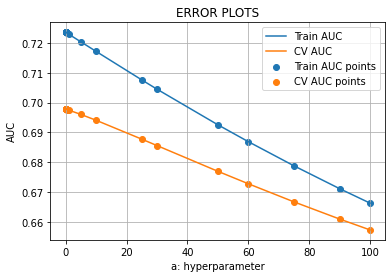

In [ ]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score
import math

train_auc = []
cv_auc = []
alphas =  [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,25,30,50,60,75,90,100]
# log_alphas = [math.log(x,10) for x in alphas]
# print(log_alphas)
for i in tqdm(alphas):
    neigh = MultinomialNB(alpha = i,class_prior = [0.5, 0.5])
    # neigh = MultinomialNB(alpha = i)
    neigh.fit(X_tr1, y_train)

    y_train_pred = batch_predict(neigh, X_tr1)    
    y_cv_pred = batch_predict(neigh, X_cv1)
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alphas, train_auc, label='Train AUC')
plt.plot(alphas, cv_auc, label='CV AUC')

plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Test Best value of param

In [ ]:
best_alpha = 2

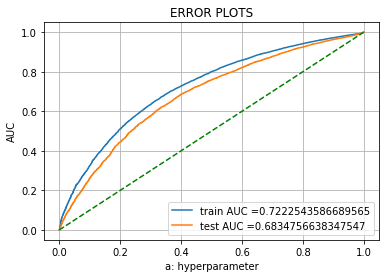

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc,accuracy_score


nb = MultinomialNB(alpha=best_alpha)
nb.fit(X_tr1, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

y_train_pred = batch_predict(nb, X_tr1)    
y_test_pred = batch_predict(nb, X_test1)

# print(accuracy_score(y_test,nb.predict(X_test)))

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.plot([0,1],[0,1],'g--')
plt.grid()
plt.show()

### Confusion Matrix

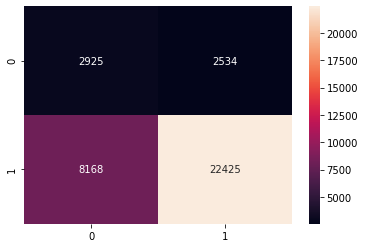

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test,nb.predict(X_test1))
# print(cf_matrix)
sns.heatmap(cf_matrix, fmt="d",annot=True, )


# Task 2 : Using TF-IDF

### TF-IDF

In [ ]:
# # train test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, stratify=Y)
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.33, stratify=y_train)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
vectorizer.fit(X_train['essay'].values) # fit has to happen only on train data
feature_list_dict["essay"] = list(vectorizer.get_feature_names())


# we use the fitted CountVectorizer to convert the text to vector
X_train_essay_tfidf = vectorizer.transform(X_train['essay'].values)
X_cv_essay_tfidf = vectorizer.transform(X_cv['essay'].values)
X_test_essay_tfidf = vectorizer.transform(X_test['essay'].values)

print(X_train_essay_tfidf.shape)

(49041, 41136)


### Concatening Features into df

In [ ]:
from scipy.sparse import hstack
X_tr2 = hstack((X_train_essay_tfidf, X_train_state_ohe, X_train_teacher_ohe, X_train_grade_ohe, X_train_sub_cat_ohe, X_train_cat_ohe,X_train_price_norm,X_train_prev_proj_norm)).tocsr()
X_cv2 = hstack((X_cv_essay_tfidf, X_cv_state_ohe, X_cv_teacher_ohe, X_cv_grade_ohe, X_cv_sub_cat_ohe, X_cv_cat_ohe,X_cv_price_norm,X_cv_prev_proj_norm)).tocsr()
X_test2 = hstack((X_test_essay_tfidf, X_test_state_ohe, X_test_teacher_ohe, X_test_grade_ohe, X_test_sub_cat_ohe, X_test_cat_ohe,X_test_price_norm,X_test_prev_proj_norm)).tocsr()

print("Final Data matrix")
print(X_tr2.shape, y_train.shape)
print(X_cv2.shape, y_cv.shape)
print(X_test2.shape, y_test.shape)
print("="*100)

Final Data matrix
(49041, 41237) (49041,)
(24155, 41237) (24155,)
(36052, 41237) (36052,)


### Apply NB with TF-IDF

In [ ]:
def batch_predict(clf, data):
  
    y_data_pred = []
    tr_loop = data.shape[0] - data.shape[0]%1000

    for i in range(0, tr_loop, 1000):
        y_data_pred.extend(clf.predict_proba(data[i:i+1000])[:,1])

    if data.shape[0]%1000 !=0:
        y_data_pred.extend(clf.predict_proba(data[tr_loop:])[:,1])
    
    return y_data_pred

100%|██████████| 14/14 [00:03<00:00,  3.71it/s]


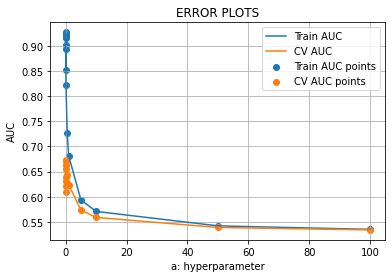

In [ ]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc = []
alphas =  [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]
# alphas = np.random.uniform(10**-2, 10**2, 100) 


for i in tqdm(alphas):
    neigh = MultinomialNB(alpha = i,class_prior = [0.5, 0.5])
    neigh.fit(X_tr2, y_train)

    y_train_pred = batch_predict(neigh, X_tr2)    
    y_cv_pred = batch_predict(neigh, X_cv2)
        
    train_auc.append(roc_auc_score(y_train,y_train_pred))
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

plt.plot(alphas, train_auc, label='Train AUC')
plt.plot(alphas, cv_auc, label='CV AUC')

plt.scatter(alphas, train_auc, label='Train AUC points')
plt.scatter(alphas, cv_auc, label='CV AUC points')

plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.grid()
plt.show()

### Test Best value of param

In [ ]:
best_alpha = 0.5

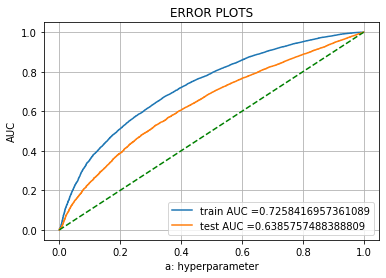

In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


nb = MultinomialNB(alpha=best_alpha)
nb.fit(X_tr2, y_train)

y_train_pred = batch_predict(nb, X_tr2)    
y_test_pred = batch_predict(nb, X_test2)

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("a: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.plot([0,1],[0,1],'g--')
plt.grid()
plt.show()

[[   57  5402]
 [   92 30501]]


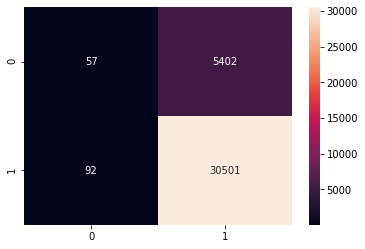

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test,nb.predict(X_test2))
print(cf_matrix)
sns.heatmap(cf_matrix,fmt="d", annot=True)

# Top 10 Features

In [ ]:
pos_class_prob = nb.feature_log_prob_[1]
pos_indices = pos_class_prob.argsort()
top_10 = pos_class_prob[pos_indices][-10:]

cats = ["essay","school_state","teacher_prefix","project_grade_category","clean_subcategories","clean_categories"]
feature_list = []
x = 0
for cat in cats:
  feature_list.extend(feature_list_dict[cat])

feature_list.append("Price")
feature_list.append("Prev_projects")


In [ ]:
r = sorted(pos_indices[-10:],reverse=True)
# print(feature_list[r])
print("***********Top 10 Features***********\n")
for i in r:
  print(feature_list[i])

***********Top 10 Features***********

math_science
literacy_language
mathematics
literature_writing
literacy
grades_prek_2
grades_6_8
grades_3_5
ms
mrs


<h1>3. Summary</h1>

|Vectorizer | Model | Hyperparameter | Train AUC | Test AUC |
| --------- | ----- | -------------- |----| ---- |
|BoW | MultinomialNB | 2 | 0.72254 | 0.683475 |
|TF-IDF | MultinomialNB | 0.5 | 0.725841 | 0.63857 |

In [ ]:
from prettytable import PrettyTable
table = PrettyTable(['Vectorizer', 'Model', 'HyperParamter (alpha)', 'Train AUC', 'Test AUC'])
table.add_row(['BoW', "MultinomialNB",2,0.72254,0.683475])
table.add_row(['TF-IDF', "MultinomialNB", 0.5,0.725841,	0.63857])
print(table)

+------------+---------------+-----------------------+-----------+----------+
| Vectorizer |     Model     | HyperParamter (alpha) | Train AUC | Test AUC |
+------------+---------------+-----------------------+-----------+----------+
|    BoW     | MultinomialNB |           2           |  0.72254  | 0.683475 |
|   TF-IDF   | MultinomialNB |          0.5          |  0.725841 | 0.63857  |
+------------+---------------+-----------------------+-----------+----------+


In [ ]:
!jupyter nbconvert --to html "/content/6_Assignment_NB_Instructions.ipynb"

[NbConvertApp] Converting notebook /content/6_Assignment_NB_Instructions.ipynb to html
[NbConvertApp] Writing 3798537 bytes to /content/6_Assignment_NB_Instructions.html
